In [ ]:
ZenML Header Image

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Why ZenML

In [ ]:
import os

os.environ['ZENML_LOGGING_VERBOSITY'] = 'INFO'
os.environ['ZENML_DEBUG'] = 'true'
os.environ['ZENML_ANALYTICS_OPT_IN'] = 'false'

In [ ]:
!rm -rf /home/hamza/temp_stuff/zenml_demo/nba-ml-pipeline/.zen
!zenml init
!zenml stack set local_stack

* Explain history
* Talk about tooling overhead
* Talk about lock-in to platforms
* Talk about extensibility
* Talk about usability

What we were looking for was basically something like a React or even Next JS
Show images of react + next js stacks? I worked on many side projects.

Show Sam picture of stacks

# Chapter 1 - Exploring NBA Data
## Did Steph Curry Change the Game?

https://www.youtube.com/watch?v=GEMVGHoenXM

![Steph Curry Drains the Game Winner vs Oklahoma City](https://i.makeagif.com/media/3-20-2016/7N5RWB.gif)

In [6]:
# We'll use this date in our pipelines
CURRYS_THREE_POINTER = '2016-02-27'

![PipelineStructure](_assets/DriftDetectionPipeline.png "PipelineStructure")

## Creating our first step

In [9]:
import pandas as pd
from nba_api.stats.endpoints import leaguegamelog

from zenml.steps import step
from src.steps.importer import ImporterConfig
import time


@step
def game_data_importer(config: ImporterConfig) -> pd.DataFrame:
    """Downloads season data from NBA API and returns a pd.DataFrame"""
    dataframes = []
    for season in config.seasons:
        print(f"Fetching data for season: {season}")
        dataframes.append(leaguegamelog.LeagueGameLog(season=season, timeout=180).get_data_frames()[0])
        # sleep so as not to bomb api server :-)
        time.sleep(2)
    return pd.concat(dataframes)

In [10]:
### Import our steps
from src.steps.importer import game_data_importer
from src.steps.splitter import date_based_splitter, SplitConfig

## Creating an exploratory pipeline

In [11]:
from zenml.pipelines import pipeline

@pipeline
def data_analysis_pipeline(
        importer,          # Import NBA game data
        drift_splitter,    # Split data at relevant date
        drift_detector,    # Compare data distributions
):
    """Links all the steps together in a pipeline"""
    raw_data = importer()
    reference_dataset, comparison_dataset = drift_splitter(raw_data)
    drift_report, _ = drift_detector(reference_dataset, comparison_dataset)

https://blog.zenml.io/zenml-loves-evidently/  

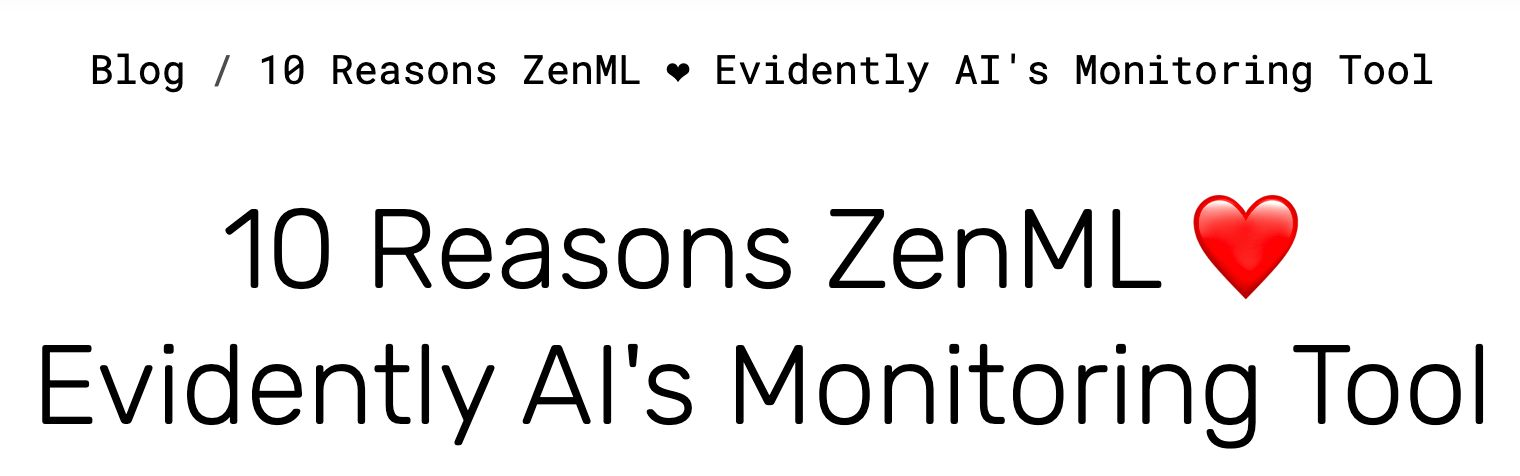

In [ ]:
!zenml integration install evidently

In [12]:
from zenml.integrations.evidently.steps import (
    EvidentlyProfileConfig,
    EvidentlyProfileStep,
)

evidently_drift_detector = EvidentlyProfileStep(
    EvidentlyProfileConfig(
        column_mapping=None,
        profile_sections=["datadrift"],
    )
)

### Run the pipeline

In [ ]:
# Initialize the pipeline
eda_pipeline = data_analysis_pipeline(
    importer=game_data_importer(),
    drift_splitter=date_based_splitter(SplitConfig(date_split=CURRYS_THREE_POINTER, columns=['FG3M'])),
    drift_detector=evidently_drift_detector,
)

eda_pipeline.run()

## Post-execution: Fetching pipelines and reviewing results

In [13]:
from zenml.integrations.evidently.visualizers import EvidentlyVisualizer
from zenml.repository import Repository
import json

repo = Repository()
p = repo.get_pipeline(pipeline_name='data_analysis_pipeline')

No pipelines found for name 'data_analysis_pipeline'


In [14]:
p.runs

AttributeError: 'NoneType' object has no attribute 'runs'

In [15]:
last_run = p.runs[-1]
last_run

AttributeError: 'NoneType' object has no attribute 'runs'

In [16]:
drift_detection_step = last_run.get_step(
    name="drift_detector"
)
drift_detection_step

NameError: name 'last_run' is not defined

In [17]:
EvidentlyVisualizer().visualize(drift_detection_step)

NameError: name 'drift_detection_step' is not defined

# Chapter 2 - Training Pipeline 

## First thoughts
![Planned Architecture](_assets/planned_architecture.png "Planned Architecture")

In [25]:
from datetime import date, timedelta
from zenml.pipelines import pipeline
from zenml.integrations.mlflow.mlflow_utils import (
    enable_mlflow,
    local_mlflow_backend,
)

@pipeline
def training_pipeline(
        importer,
        feature_engineerer,
        encoder,
        ml_splitter,
        trainer,
        tester,
        drift_splitter,
        drift_detector,
        drift_alert
):
    """Links all the steps together in a pipeline"""
    # Data Preprocessing
    raw_data = importer()
    transformed_data = feature_engineerer(raw_data)
    encoded_data, le_seasons, ohe_teams = encoder(transformed_data)
    train_df_x, train_df_y, test_df_x, test_df_y, eval_df_x, eval_df_y = ml_splitter(encoded_data)
    
    # Model training
    model = trainer(train_df_x, train_df_y, eval_df_x, eval_df_y)
    test_results = tester(model, test_df_x, test_df_y)

    # drift detection branch
    reference_dataset, comparison_dataset = drift_splitter(raw_data)
    drift_report, _ = drift_detector(reference_dataset, comparison_dataset)
    drift_alert(drift_report)

In [26]:
from src.steps.analyzer import analyze_drift
from src.steps.encoder import data_encoder
from src.steps.evaluator import tester
from src.steps.feature_engineer import feature_engineer
from src.steps.importer import game_data_importer
from src.steps.splitter import sklearn_splitter, SklearnSplitterConfig, reference_data_splitter, TrainingSplitConfig
from src.steps.trainer import random_forest_trainer
from src.steps.discord_bot import discord_alert

ONE_WEEK_AGO = (date.today() - timedelta(days=7)).strftime("%Y-%m-%d")


# Initialize the pipeline
train_pipeline = training_pipeline(
    # Data Wrangling
    importer=game_data_importer(),
    feature_engineerer=feature_engineer(),
    encoder=data_encoder(),
    ml_splitter=sklearn_splitter(SklearnSplitterConfig(ratios={'train': 0.6, 'test': 0.2, 'validation': 0.2})),
    
    # Model training
    trainer=random_forest_trainer(),
    tester=tester(),
    
    # Drift detection
    drift_splitter=reference_data_splitter(
        TrainingSplitConfig(
            new_data_split_date=ONE_WEEK_AGO,
            start_reference_time_frame=CURRYS_THREE_POINTER,
            end_reference_time_frame=ONE_WEEK_AGO,
            columns=["FG3M"])),
    
    drift_detector=EvidentlyProfileStep(
        EvidentlyProfileConfig(
            column_mapping=None,
            profile_sections=["datadrift"])),
    
    # Alert discord
    drift_alert=discord_alert(),
)

train_pipeline.run()

Creating run for pipeline: `training_pipeline`
Cache enabled for pipeline `training_pipeline`
Using stack `local_stack` to run pipeline `training_pipeline`...
Step `game_data_importer` has started.
Step `game_data_importer` has finished in 0.078s.
Step `feature_engineer` has started.
Step `feature_engineer` has finished in 0.056s.
Step `reference_data_splitter` has started.
Step `reference_data_splitter` has finished in 0.054s.
Step `EvidentlyProfileStep` has started.
Step `EvidentlyProfileStep` has finished in 0.051s.
Step `data_encoder` has started.
Step `data_encoder` has finished in 0.130s.
Step `alert_drift` has started.
Payload delivered successfully, code 204.
No drift detected
Step `alert_drift` has finished in 0.396s.
Step `sklearn_splitter` has started.
Step `sklearn_splitter` has finished in 0.289s.
Step `random_forest_trainer` has started.
Eval score is: -0.037652791801596974
Step `random_forest_trainer` has finished in 1.573s.
Step `tester` has started.
Mean Absolute Error

In [28]:
from zenml.integrations.evidently.visualizers import EvidentlyVisualizer
from zenml.repository import Repository


last_week = date.today() - timedelta(days=7)
ONE_WEEK_AGO = last_week.strftime("%Y-%m-%d")
CURRY_FROM_DOWNTOWN = '2016-02-27'


repo = Repository()
p = repo.get_pipeline(pipeline_name='training_pipeline')
last_run = p.runs[-1]
drift_analysis_step = last_run.get_step(
    name="drift_alert"
)
print(f'Data drift detected: {drift_analysis_step.output.read()}')

drift_detection_step = last_run.get_step(
    name="drift_detector"
)
evidently_outputs = drift_detection_step

EvidentlyVisualizer().visualize(evidently_outputs)

KeyError: "No step found for name `drift_alert`. This pipeline run only has steps with the following names: `['importer', 'feature_engineerer', 'drift_splitter', 'drift_detector', 'encoder', 'drift_alerter', 'ml_splitter', 'trainer', 'tester']`"

In [29]:
!zenml stack list

STACKS:
ACTIVE    NAME         ORCHESTRATOR        METADATA_STORE        ARTIFACT_STORE        CONTAINER_REGISTRY
--------  -----------  ------------------  --------------------  --------------------  --------------------
*         local_stack  local_orchestrator  local_metadata_store  local_artifact_store


## Zenml Stacks

### From Local

![LocalStack](_assets/localstack.png "LocalStack")

### To Kubeflow

![KubeflowStack](_assets/localstack-with-kubeflow-orchestrator.png "KubeflowStack")

In [ ]:
!zenml stack set local_kubeflow_stack
# Lets train within kubeflow pipelines
!python src/pipelines/training_pipeline.py

# Chapter 3 - The Prediction Pipeline

In [ ]:
# Let's return to our local stack
!zenml stack set local_stack

In [ ]:
@pipeline(enable_cache=False)
def inference_pipeline(
        importer,
        preprocessor,
        extract_next_week,
        model_picker,
        predictor,
):
    """Links all the steps together in a pipeline"""
    season_schedule = importer()
    processed_season_schedule = preprocessor(season_schedule)
    upcoming_week = extract_next_week(processed_season_schedule)
    model, run_id = model_picker()
    predictions = predictor(model, upcoming_week)
    
    
    # drift detection branch
    reference_dataset, comparison_dataset = drift_splitter(season_schedule)
    drift_report, _ = drift_detector(reference_dataset, comparison_dataset)
    drift_alert(drift_report)

In [ ]:
from src.steps.encoder import encode_columns_and_clean
from src.steps.importer import import_season_schedule, SeasonScheduleConfig
from src.steps.model_picker import model_picker
from src.steps.predictor import predictor
from src.steps.splitter import get_coming_week_data, TimeWindowConfig

# Initialize the pipeline
inference_pipe = inference_pipeline(
    importer=import_season_schedule(
        SeasonScheduleConfig(current_season='2021-22')),
    preprocessor=encode_columns_and_clean(),
    extract_next_week=get_coming_week_data(TimeWindowConfig(time_window=7)),
    model_picker=model_picker(),
    predictor=predictor()
)

inference_pipe.run()

In [ ]:
# Lets have a look at some of our predictions

r = Repository()
r.get_pipeline(pipeline_name='inference_pipeline').runs[-1].steps[-1].output.read().head(20)